# 猫狗大战毕业项目

## 探索性可视化

In [1]:
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import cv2

%matplotlib inline

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


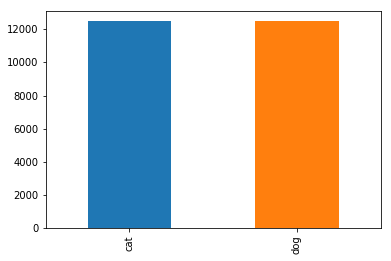

In [2]:
img_files = [f for f in listdir('./train') if isfile(join('./train', f))]
img_data = defaultdict(list)
for img_file in img_files:
    img_data[img_file[:3]].append(img_file)

img_data = pd.DataFrame(img_data)
img_data = pd.Series([img_data['cat'].count(), img_data['dog'].count()], index=['cat', 'dog'])
img_data.plot(kind='bar')

训练集中猫和狗的图片各占一半，分别为12500张。

## 数据预处理

通过研究[清单](https://gist.github.com/aaronpolhamus/964a4411c0906315deb9f4a3723aac57)可以知道ImageNet的1000种分类中狗和猫对应的标签，可以根据这个信息快速构建自己的异常值检测器。

In [3]:
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input as xception_preprocess
from keras.applications.xception import decode_predictions as xception_decode

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as inception_preprocess
from keras.applications.inception_v3 import decode_predictions as inception_decode

from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input as resnet_preprocess
from keras.applications.resnet50 import decode_predictions as resnet_decode

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as vgg16_preprocess
from keras.applications.vgg16 import decode_predictions as vgg16_decode

from keras.preprocessing import image

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
dogs = [
    'n02085620','n02085782','n02085936','n02086079', 
    'n02086240','n02086646','n02086910','n02087046',
    'n02087394','n02088094','n02088238','n02088364',
    'n02088466','n02088632','n02089078','n02089867',
    'n02089973','n02090379','n02090622','n02090721',
    'n02091032','n02091134','n02091244','n02091467',
    'n02091635','n02091831','n02092002','n02092339',
    'n02093256','n02093428','n02093647','n02093754',
    'n02093859','n02093991','n02094114','n02094258',
    'n02094433','n02095314','n02095570','n02095889',
    'n02096051','n02096177','n02096294','n02096437',
    'n02096585','n02097047','n02097130','n02097209',
    'n02097298','n02097474','n02097658','n02098105',
    'n02098286','n02098413','n02099267','n02099429',
    'n02099601','n02099712','n02099849','n02100236',
    'n02100583','n02100735','n02100877','n02101006',
    'n02101388','n02101556','n02102040','n02102177',
    'n02102318','n02102480','n02102973','n02104029',
    'n02104365','n02105056','n02105162','n02105251',
    'n02105412','n02105505','n02105641','n02105855',
    'n02106030','n02106166','n02106382','n02106550',
    'n02106662','n02107142','n02107312','n02107574',
    'n02107683','n02107908','n02108000','n02108089',
    'n02108422','n02108551','n02108915','n02109047',
    'n02109525','n02109961','n02110063','n02110185',
    'n02110341','n02110627','n02110806','n02110958',
    'n02111129','n02111277','n02111500','n02111889',
    'n02112018','n02112137','n02112350','n02112706',
    'n02113023','n02113186','n02113624','n02113712',
    'n02113799','n02113978']

cats = [
    'n02123045','n02123159','n02123394','n02123597',
    'n02124075','n02125311','n02127052',
]

In [5]:
np.random.RandomState(42).shuffle(img_files)

def abnormals_detect(detector, img_files, top, preprocess, decode):
    abnormals = []
    for img_file in img_files:
        img = image.load_img('./train/'+img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess(x)

        preds = detector.predict(x)
        preds = decode(preds, top=top)
        dog_or_cat_found = False
        for pred in preds[0]:
            if pred[0] in dogs or pred[0] in cats:
                dog_or_cat_found = True
            
        if not dog_or_cat_found:
            abnormals.append(img_file)
    return abnormals

def display_image(img_paths):
    for path in img_paths:
        img = cv2.imread('./train/'+path)
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(cv_rgb)
        plt.show()


15 abnormals detected: ['cat.6213.jpg', 'cat.7932.jpg', 'cat.5168.jpg', 'cat.1757.jpg', 'cat.796.jpg', 'cat.5092.jpg', 'cat.11706.jpg', 'cat.9377.jpg', 'dog.10297.jpg', 'dog.3629.jpg', 'cat.12493.jpg', 'dog.11299.jpg', 'cat.4982.jpg', 'cat.1204.jpg', 'cat.7545.jpg']


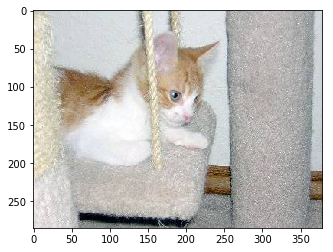

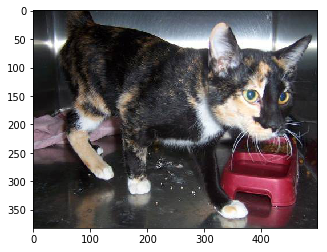

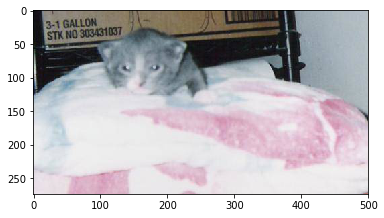

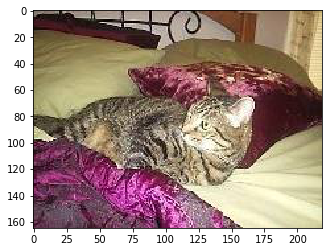

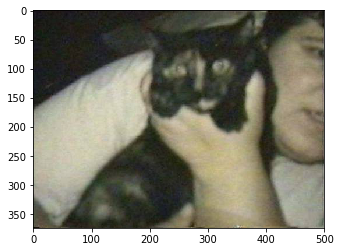

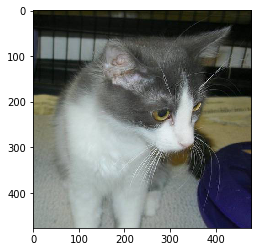

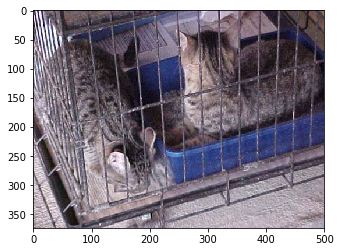

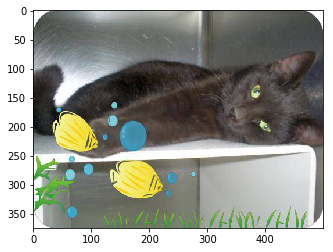

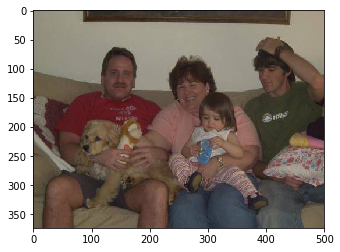

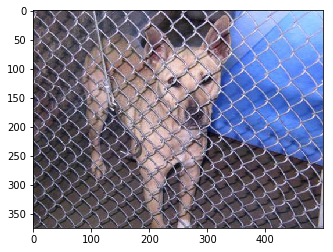

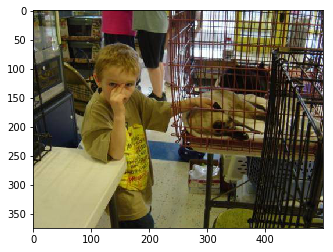

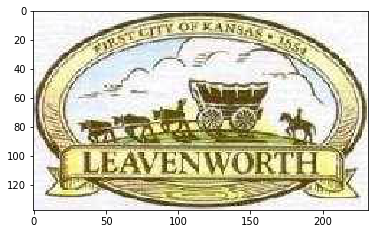

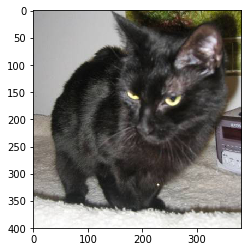

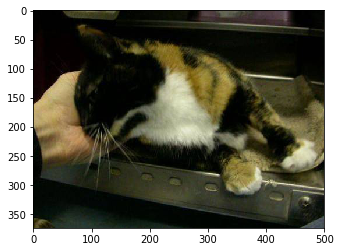

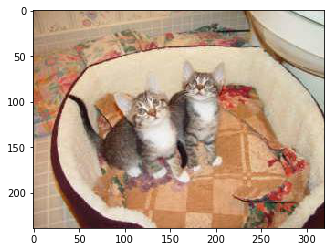

In [6]:
xception_detector = Xception(weights='imagenet')
xception_abnormals = abnormals_detect(xception_detector, img_files[:1000], 5, xception_preprocess, xception_decode)
print('{} abnormals detected: {}'.format(len(xception_abnormals), xception_abnormals))
display_image(xception_abnormals)

根据[Keras文档](https://keras.io/applications/)，准确率最高的模型是Xception，其Top-1和Top-5准确率分别为0.790和0.945。先以这个模型作为检测器，以1000张混洗过的图片作为样本，看看Top-5下都有哪些图片被识别为非猫非狗，检测出来有14张异常值，误报率较高，但的确也发现了 一些有问题的图片，比如有1张就是非猫非狗。下面将Top值提高到10看看。

6 abnormals detected: ['cat.5168.jpg', 'cat.9377.jpg', 'dog.10297.jpg', 'cat.12493.jpg', 'dog.11299.jpg', 'cat.7545.jpg']


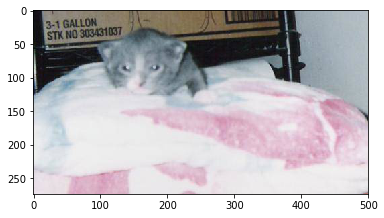

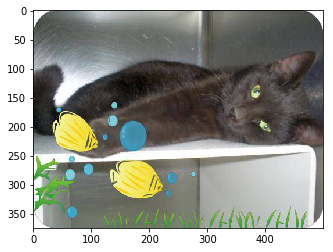

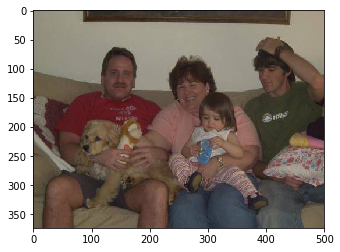

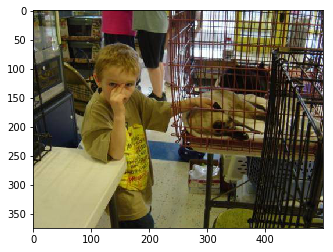

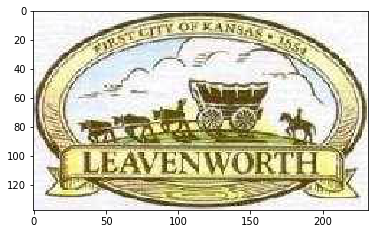

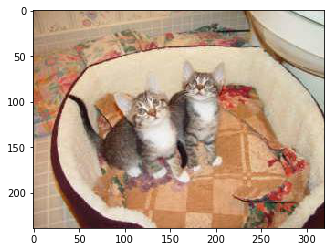

In [7]:
xception_abnormals = abnormals_detect(xception_detector, img_files[:1000], 10, xception_preprocess, xception_decode)
print('{} abnormals detected: {}'.format(len(xception_abnormals), xception_abnormals))
display_image(xception_abnormals)

误报率仍然比较高，下面再分别试验下Top-20和Top-30。

2 abnormals detected: ['dog.10297.jpg', 'dog.11299.jpg']


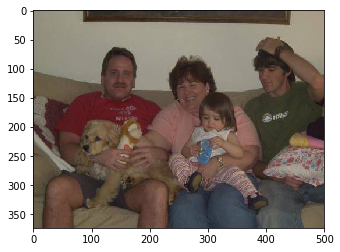

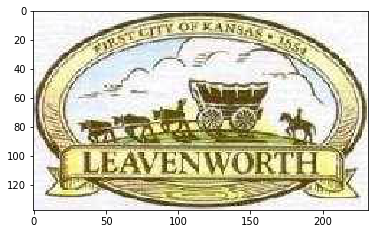

In [8]:
xception_abnormals = abnormals_detect(xception_detector, img_files[:1000], 20, xception_preprocess, xception_decode)
print('{} abnormals detected: {}'.format(len(xception_abnormals), xception_abnormals))
display_image(xception_abnormals)

1 abnormals detected: ['dog.11299.jpg']


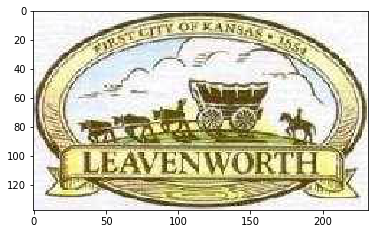

In [9]:
xception_abnormals = abnormals_detect(xception_detector, img_files[:1000], 30, xception_preprocess, xception_decode)
print('{} abnormals detected: {}'.format(len(xception_abnormals), xception_abnormals))
display_image(xception_abnormals)

从得到的结果可以看出Top值为30时检测到了1张图片，该图片是一个商标，既不是猫也不是狗，下面把样本数量提高到5000，再看看检测结果。

12 abnormals detected: ['dog.11299.jpg', 'cat.2975.jpg', 'cat.8383.jpg', 'dog.5604.jpg', 'cat.8470.jpg', 'dog.11437.jpg', 'cat.5974.jpg', 'dog.6475.jpg', 'dog.10237.jpg', 'dog.10801.jpg', 'cat.5071.jpg', 'cat.10029.jpg']


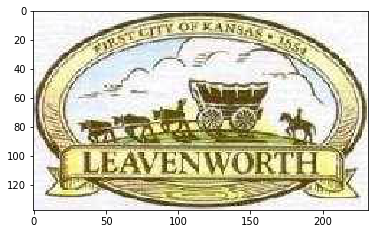

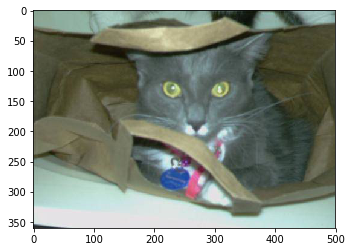

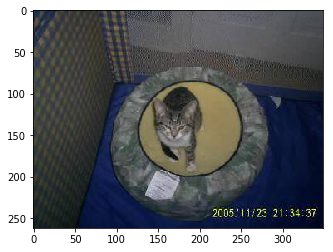

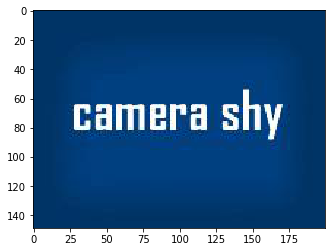

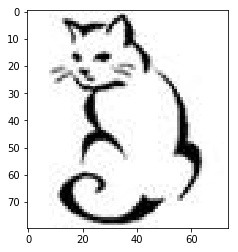

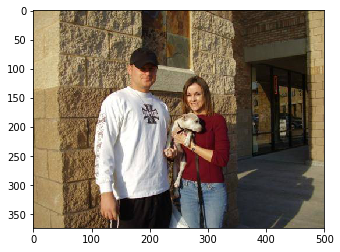

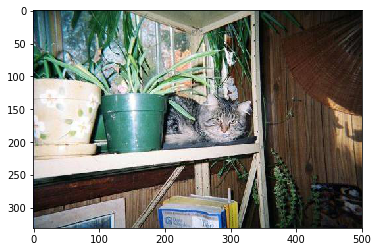

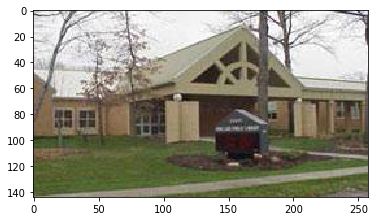

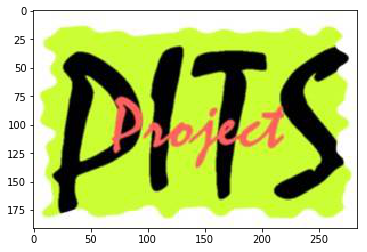

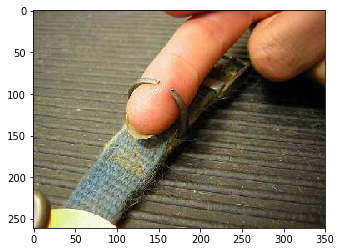

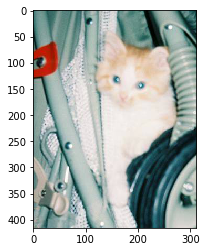

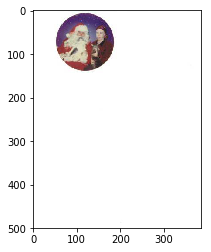

In [10]:
xception_abnormals = abnormals_detect(xception_detector, img_files[:5000], 30, xception_preprocess, xception_decode)
print('{} abnormals detected: {}'.format(len(xception_abnormals), xception_abnormals))
display_image(xception_abnormals)

上面5000个样本的检测结果显示的确有一些图片既不是猫也不是狗，但还是有一些正常的图片被误报了，不算太理想，把Top值提高到60，样本数量提高到10000再看看。

9 abnormals detected: ['dog.11299.jpg', 'dog.5604.jpg', 'cat.8470.jpg', 'cat.5974.jpg', 'dog.10801.jpg', 'cat.10029.jpg', 'cat.8456.jpg', 'dog.10161.jpg', 'dog.4367.jpg']


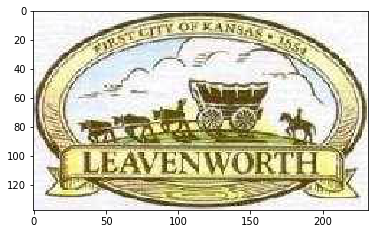

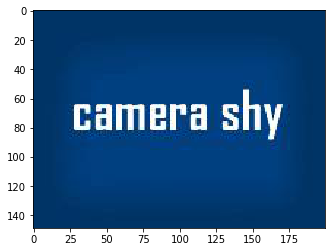

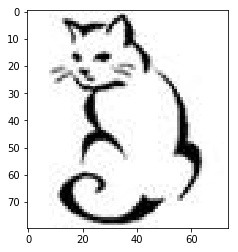

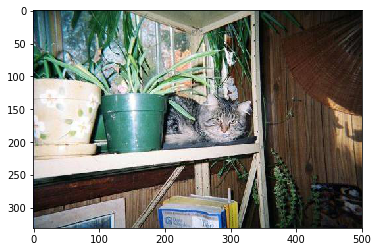

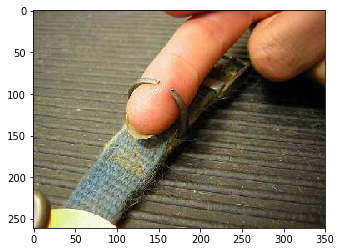

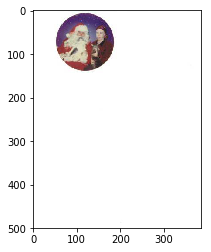

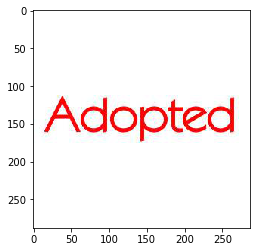

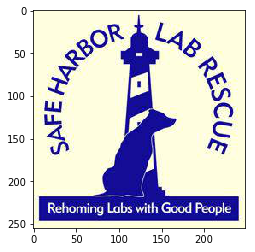

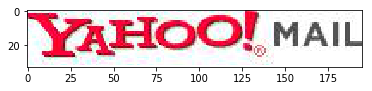

In [11]:
xception_abnormals = abnormals_detect(xception_detector, img_files[:10000], 60, xception_preprocess, xception_decode)
print('{} abnormals detected: {}'.format(len(xception_abnormals), xception_abnormals))
display_image(xception_abnormals)

从10000张图片中检测出来17张图片，其中有很多是非猫非狗的异常图片，虽然也有一部分图片被误报了，但是都属于图片内容比较复杂或者质量不高的，因此Top值为60是一个比较理想的值，下面结合4种模型，对整个训练集图片进行检测，然后将结果合并起来得到最终的异常值检测结果。

In [12]:
xception_abnormals = abnormals_detect(xception_detector, img_files, 60, xception_preprocess, xception_decode)
print('{} abnormals detected by Xception'.format(len(xception_abnormals)))

39 abnormals detected by Xception


In [14]:
resnet_detector = ResNet50(weights='imagenet')
resnet_abnormals = abnormals_detect(resnet_detector, img_files, 60, resnet_preprocess, resnet_decode)
print('{} abnormals detected by ResNet'.format(len(resnet_abnormals)))

34 abnormals detected by ResNet


In [15]:
inception_detector = InceptionV3(weights='imagenet')
inception_abnormals = abnormals_detect(inception_detector, img_files, 60, inception_preprocess, inception_decode)
print('{} abnormals detected by Inception'.format(len(inception_abnormals)))

96116736/96112376 [==============================] - 1s 0us/step
23 abnormals detected by Inception


In [16]:
vgg16_detector = VGG16(weights='imagenet')
vgg16_abnormals = abnormals_detect(vgg16_detector, img_files, 60, vgg16_preprocess, vgg16_decode)
print('{} abnormals detected by VGG16'.format(len(vgg16_abnormals)))

553467904/553467096 [==============================] - 6s 0us/step
93 abnormals detected by VGG16


In [19]:
total_abnormals = set().\
union(set(xception_abnormals)).\
union(set(resnet_abnormals)).\
union(set(inception_abnormals)).\
union(set(vgg16_abnormals))

print('{} abnormals detected: {}'.format(len(total_abnormals), list(total_abnormals)))


118 abnormals detected: ['cat.9494.jpg', 'dog.3074.jpg', 'dog.10123.jpg', 'cat.2691.jpg', 'cat.7314.jpg', 'cat.6614.jpg', 'cat.8383.jpg', 'cat.9391.jpg', 'cat.596.jpg', 'cat.3758.jpg', 'dog.8450.jpg', 'dog.1259.jpg', 'cat.3739.jpg', 'dog.9188.jpg', 'cat.8138.jpg', 'cat.8456.jpg', 'dog.10155.jpg', 'dog.6405.jpg', 'cat.9983.jpg', 'dog.1895.jpg', 'dog.4127.jpg', 'cat.2845.jpg', 'dog.2614.jpg', 'dog.5602.jpg', 'dog.4367.jpg', 'dog.6733.jpg', 'dog.1546.jpg', 'dog.9705.jpg', 'cat.10365.jpg', 'cat.8921.jpg', 'dog.5604.jpg', 'dog.2422.jpg', 'cat.5954.jpg', 'cat.7564.jpg', 'cat.4577.jpg', 'dog.12148.jpg', 'dog.1625.jpg', 'dog.806.jpg', 'cat.9624.jpg', 'cat.3672.jpg', 'dog.3341.jpg', 'cat.4338.jpg', 'cat.7377.jpg', 'dog.4507.jpg', 'cat.2520.jpg', 'cat.12272.jpg', 'dog.11248.jpg', 'cat.6345.jpg', 'dog.10237.jpg', 'cat.4833.jpg', 'dog.5618.jpg', 'dog.8898.jpg', 'cat.10700.jpg', 'dog.4218.jpg', 'cat.11504.jpg', 'cat.11373.jpg', 'dog.10801.jpg', 'dog.10190.jpg', 'dog.10225.jpg', 'cat.10712.jpg', 'do

综合四种模型输出的结果得到118张图片，通过人工分析发现这些被判定为异常值的图片有以下几种类型：

1. 图片中有猫狗，但尺寸太小，不够清晰；
2. 图片中有猫狗，但内容比较复杂；
3. 图片非猫非狗；
4. 图片是猫和狗的卡通形象；

我认为情况1应该保留，因为这里不能假定所有输入模型的图片都是清晰的，总会有一些模糊的图片，模型应当对这样的图片具有一定的健壮性；情况2也应该保留，模型也应该对一些复杂的图片具有一定的健壮性；情况3应该删除；情况4则比较主观，但我训练该模型的目的是为了识别真实世界的猫狗，所以我选择删除。最终被删除的有38张图片。

In [21]:
import os

deleted = [
    'dog.10190.jpg', 'cat.7377.jpg', 'cat.5418.jpg', 'dog.8898.jpg', 'dog.10747.jpg',
    'dog.6475.jpg', 'cat.11184.jpg', 'cat.4833.jpg', 'dog.1895.jpg', 'cat.10029.jpg',
    'dog.1308.jpg', 'dog.8736.jpg', 'cat.12272.jpg', 'dog.11299.jpg', 'cat.7968.jpg',
    'cat.2939.jpg', 'dog.4367.jpg', 'cat.5351.jpg', 'dog.10237.jpg', 'cat.8456.jpg',
    'dog.5604.jpg', 'dog.1773.jpg', 'dog.3889.jpg', 'cat.9171.jpg', 'cat.4338.jpg',
    'cat.7564.jpg', 'dog.9517.jpg', 'dog.12376.jpg', 'cat.4688.jpg', 'dog.9188.jpg',
    'dog.10801.jpg', 'dog.1194.jpg', 'dog.10161.jpg', 'dog.1259.jpg', 'cat.10712.jpg',
    'dog.2614.jpg', 'cat.8470.jpg', 'cat.3672.jpg',
]

for image in deleted:
    os.remove('./train/'+image)

In [32]:
img_files = [f for f in listdir('./train') if isfile(join('./train', f))]
img_data = defaultdict(list)
for img_file in img_files:
    img_data[img_file[:3]].append(img_file)

print('{} in total, cat {}, dog {}'.format(len(img_files), len(img_data['cat']), len(img_data['dog'])))

24962 in total, cat 12483, dog 12479


清洗后的训练集图片有24962张，其中猫有12483张，狗有12479张。

## 执行过程

### 创建目录结构
为了方便之后使用Keras的ImageDataGenerator，需要创建一个新文件夹trains，然后把猫和狗的照片分别放到其下的子文件夹cats和dogs中，为了节约磁盘空间，这里使用符号连接来实现。

In [4]:
import os
import shutil

image_files = os.listdir('./train')
cat_images = filter(lambda x: x[:3] == 'cat', image_files)
dog_images = filter(lambda x: x[:3] == 'dog', image_files)

def mkdir_from_scratch(dir_name):
    if os.path.exists(dir_name):
        shutil.rmtree(dir_name)
    os.mkdir(dir_name)
    
mkdir_from_scratch('./trains')
os.mkdir('./trains/cats')
os.mkdir('./trains/dogs')

mkdir_from_scratch('./tests')
os.symlink('../test', './tests/test')

for image in cat_images:
    os.symlink('../../train/'+image, './trains/cats/'+image)
    
for image in dog_images:
    os.symlink('../../train/'+image, './trains/dogs/'+image)

### 导出特征向量
### 载入特征向量
### 构建模型
### 训练模型
### 预测测试集
### 优化